In [0]:
!chmod +x get_data.sh
!./get_data.sh

In [0]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.models.unet import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
#from PIL import Image
import re
from fastai.callbacks import Hooks
from fastai.callbacks.hooks import *

# 1. Getting the paths of the images

In [0]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [0]:
paths = getListOfFiles('data/news')

In [4]:
videos = []
for path in paths:
    videos.append(re.findall(r'.*/(.*)/.*',path)[0])

videos = list(set(videos))
videos

['news']

# 2. Creating the Datasets, Dataloaders and Databunch

In [0]:
#this class for videos that need more than one block
class CustomDataset(Dataset):
    def __init__(self,paths,n_ref=1,block_size=(240,240),tfms = None):
        self.paths = paths
        self.n_ref = n_ref
        self.block_size = block_size
        self.nblocks = 6 #for 720x480 videos
        self.h_steps = 3 #we can fit 3 blocks horizontally
        self.v_steps = 2 #we can fit 2 blocks vertically
        self.videos = None
        self.spaths = []
        self.tfms = tfms
        self.update_params()
        
    def update_params(self):
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        self.videos = list(set(videos))
        
        df = pd.DataFrame(zip(videos,paths),columns=['video','path'])
        
        for video in self.videos:
            aux = list(df.loc[df.video==video]['path'])
            aux.sort(key=lambda f:int(re.sub('\D','',f)))
            self.spaths.extend(aux)

    def __len__(self): return (len(self.paths) - self.n_ref)*6
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        idx_frame = idx//self.nblocks 
        paths = self.spaths[idx_frame:idx_frame+self.n_ref:1] #the last one is the target
        
        frames = []
        for path in paths:
            frames.append(io.imread(path))
                 
        idx_block = idx%self.nblocks #indicates which block I'm trying to predict
                 
        #apply the transforms to the frames         
        if self.tfms: 
            for frame in frames:
                frame = self.tfms(Image.fromarray(frame))
                start_h_mult = idx_block % self.h_steps
                start_v_mult = idx_block % self.v_steps
                frame = frame[:,240*start] #TODO

In [0]:
#this class for videos that need only one block
class CustomDataset(Dataset):
    def __init__(self,paths,n_ref=1,block_size=(240,240),tfms = None,valid=False,valid_pct=0.2):
        self.paths = paths
        self.n_ref = n_ref
        self.block_size = block_size
        self.videos = None
        self.spaths = []
        self.tfms = tfms
        self.valid = valid
        self.valid_pct = valid_pct
        self.update_params()
        
    def update_params(self):
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        self.videos = list(set(videos))
        
        df = pd.DataFrame(zip(videos,paths),columns=['video','path'])
        
        for video in self.videos:
            #import pdb;pdb.set_trace()
            aux = list(df.loc[df.video==video]['path'])
            aux.sort(key=lambda f:int(re.sub('\D','',f)))
            nframes = len(aux)
            if not self.valid: self.spaths.extend(aux[:int(nframes*(1-self.valid_pct))])
            if self.valid: self.spaths.extend(aux[-int(nframes*(self.valid_pct)):])

    def __len__(self): return len(self.spaths) - self.n_ref - len(self.videos)
    
    def check(self,idx):
        paths = self.spaths[idx:idx+self.n_ref+1:1]
        videos = []
        for path in paths: videos.append(re.findall(r'.*/(.*)/.*',path)[0])
        if len(list(set(videos))) == 1: return True #if all frames are from the same video
        else: return False
        
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        is_same_video = self.check(idx)
        if not is_same_video: idx = idx+self.n_ref
            
        paths = self.spaths[idx:idx+self.n_ref+1:1] #the last one is the target
        
        frames = []
        for path in paths:
            frames.append(torch.from_numpy(io.imread(path).astype("float32").transpose(2,0,1))/255)
                
        #apply the transforms
        if self.tfms:
            norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            tfms_frames = []
            for i,frame in enumerate(frames):
                frame = fastai.vision.Image(frame)
                if i==0:
                    frame = frame.apply_tfms(self.tfms, size=self.block_size)
                else:
                    frame = frame.apply_tfms(self.tfms, size=self.block_size, do_resolve=False)
                tfms_frames.append(norm(frame.data))
            
        input,target = (torch.cat(tfms_frames[:self.n_ref]),tfms_frames[-1])
        return input,target
    
    def show(self,idx,figsize=(15, 15)):
        
        x,y = self.__getitem__(idx)
        imgs = []
        idx = 0
        for _ in range(int(x.shape[0]/3)): 
            imgs.append(x[idx:idx+3])
            idx+=3
        imgs.append(y)
        f, ax = plt.subplots(1,len(imgs),figsize=figsize)
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        for i,frame in enumerate(imgs):
            x = (frame.numpy().transpose((1,2,0))*stds + means)*255
            ax[i].imshow(x.astype(np.uint8),)
            if i < len(imgs)-1:
                ax[i].title.set_text('Ref Frame {}'.format(i))
            else:
                ax[i].title.set_text('Target Frame')

In [0]:
tfms = get_transforms(do_flip=False,max_rotate=2.5,max_warp=None)

In [0]:
train_ds = CustomDataset(paths,tfms=tfms[0],valid=False,n_ref=2,block_size=(240,240))
valid_ds = CustomDataset(paths,tfms=tfms[1],valid=True,n_ref=2,block_size=(240,240))

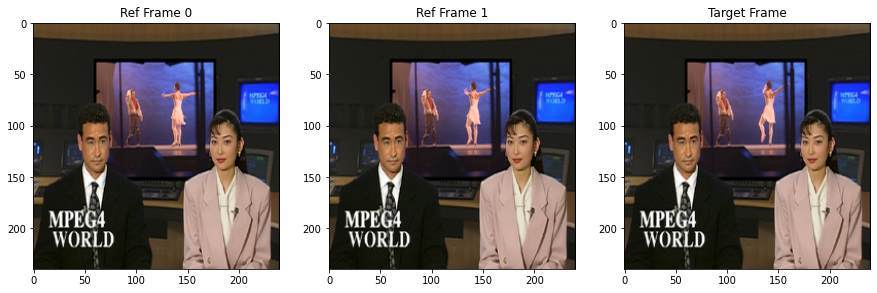

In [8]:
train_ds.show(0)

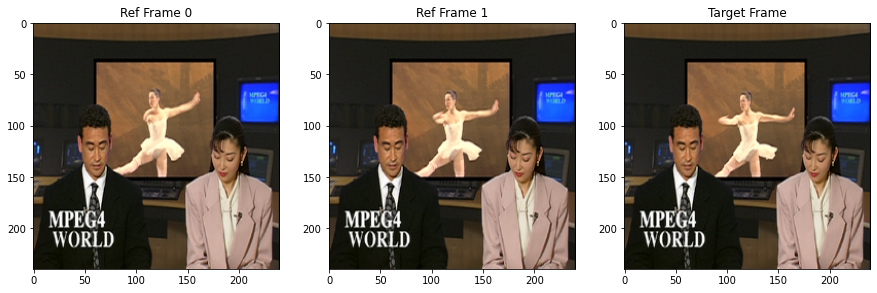

In [9]:
valid_ds.show(0)

In [11]:
len(train_ds)

237

In [0]:
train_dl = DataLoader(train_ds,batch_size=4, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds,batch_size=4, shuffle=True, num_workers=2)

In [0]:
data = DataBunch(train_dl,valid_dl)

# 3. Creating the model

## 3.1. Defining the encoder

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
input,target = next(iter(train_dl))

In [0]:
class CNNEncoder(nn.Module):
    def __init__(self,arch):
        super(CNNEncoder,self).__init__()
        self.arch = nn.Sequential(*list(arch.children())[:-2])
    def forward(self,x):
        #import pdb;pdb.set_trace()
        n = x.shape[1]//3
        #import pdb;pdb.set_trace()
        out = []
        i=0
        for _ in range(n):
            #import pdb;pdb.set_trace()
            encoding = self.arch(x[:,i:i+3,:,:]).squeeze().unsqueeze(0)
            #import pdb;pdb.set_trace()
            if len(encoding.shape) != 5: encoding = encoding.unsqueeze(1)
            out.append(encoding)
            i+=3
        return torch.cat(out)

In [0]:
cnn_encoded_sz = 32768
lin_enc_sz = 16384

arch = models.resnet18(pretrained=True)
cnn_encoder = CNNEncoder(arch)
flat = Lambda(lambda x: x.flatten(start_dim=2))
enc_drop = nn.Dropout(p=0)
enc_lin = nn.Linear(cnn_encoded_sz,lin_enc_sz)
lstm = nn.Sequential(nn.LSTM(input_size=lin_enc_sz,hidden_size=lin_enc_sz, num_layers=1), Lambda(lambda x: x[0][-1]))
dec_lin = nn.Linear(lin_enc_sz,cnn_encoded_sz)
reshape = Lambda(lambda x: x.view(x.shape[0], 512, 8, 8))
#reshape = Lambda(lambda x: x[0][-1].unsqueeze(-1).unsqueeze(-1))
#seq_encoder = nn.Sequential(cnn_encoder,lstm,reshape)
seq_encoder = nn.Sequential(cnn_encoder,flat,enc_drop,enc_lin,lstm,dec_lin,reshape)

In [18]:
xb = torch.rand([4, 6, 240, 240])
encoded = seq_encoder(xb)
encoded.shape

torch.Size([4, 512, 8, 8])

## 3.2. Putting a Unet Decoder (without skip connections) on top of the Encoder

In [0]:
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [0]:
#unet block without skip connections
class UnetBlock(Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        self.hook = hook
        self.up_in_c= up_in_c
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = (up_in_c//2)# + x_in_c)//3
        #import pdb;pdb.set_trace()
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(up_out)
        #import pdb;pdb.set_trace()
        return self.conv2(self.conv1(cat_x))

In [0]:
class DynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, cnn_encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
        sfs_szs = model_sizes(cnn_encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([cnn_encoder[i] for i in sfs_idxs], detach=False)
        x = dummy_eval(cnn_encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_layer(ni, n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()


In [0]:
model = DynamicUnet(seq_encoder, cnn_encoder.arch, n_classes=3, img_size=(240,240), blur=False, blur_final=True,
        self_attention=False, y_range=None, norm_type=None, last_cross=False,
        bottle=True)

In [23]:
model(input).shape

torch.Size([4, 3, 240, 240])

# 4. Creating the Learner and Training the Model

In [0]:
learn = Learner(data,model,loss_func = nn.MSELoss(), metrics=mean_absolute_error, callback_fns=ShowGraph)

#creates the layer groups
learn.split([learn.model[0][0].arch[:6],
            learn.model[0][0].arch[6:],
            learn.model[0][1:],
            learn.model[1:]])


#I'll fit the lstm, the convolutional decoder and the batch norm layers on the encoder
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


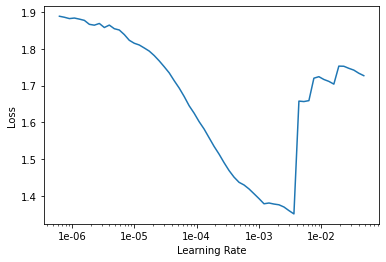

In [25]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save("stage-0")

In [0]:
learn.load("stage-0");

In [28]:
#callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')]
learn.fit_one_cycle(100,max_lr=5e-4)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.922301,0.771136,0.642505,00:10
1,0.744546,0.627702,0.569816,00:10
2,0.649825,0.584350,0.567373,00:10
3,0.597593,0.534036,0.507681,00:10
4,0.543241,0.468899,0.481794,00:10
5,0.521231,0.445759,0.470580,00:10
6,0.488489,0.421922,0.439715,00:10
7,0.444767,0.377283,0.419946,00:10
8,0.442303,0.411322,0.436359,00:10
9,0.421204,0.369342,0.407067,00:10


In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
def show_results(learn,figsize=(10,10)):
    inputs,classes = next(iter(learn.data.train_dl))
    learn.model.eval()
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0][-3:].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    inp = inp.astype('uint8')
    target = target.astype('uint8')
    pred = pred.astype('uint8')
    inp = inp.astype('float32')
    target = target.astype('float32')
    pred = pred.astype('float32')

    #mse_pred = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    mse_pred = mean_squared_error(target.flatten(),pred.flatten())
    psnr_pred = 20*np.log10(255/np.sqrt(mse_pred))

    print('MSE for pred:',mse_pred)
    print('PSNR for pred:', psnr_pred)

    #mse_inp = np.sum(((inp - target)**2))/(inp.shape[0]*inp.shape[1]*inp.shape[2])
    mse_inp = mean_squared_error(target.flatten(),inp.flatten())
    psnr_inp = 20*np.log10(255/np.sqrt(mse_inp))

    print('MSE for input:',mse_inp)
    print('PSNR for input:',psnr_inp)

    #import pdb;pdb.set_trace()

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Last Reference')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
#_ = learn.load('stage-1')

MSE for pred: 804.1963
PSNR for pred: 19.077183043592562
MSE for input: 3.6640973
PSNR for input: 42.49113387612131


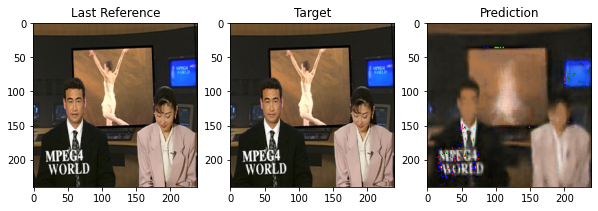

In [43]:
show_results(learn)